In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
from copy import deepcopy
from statsmodels.tsa.stattools import adfuller
import datetime
import calendar

sns.set(rc={'figure.figsize':(16,9)})

# 0.1 Global Variables 

Section reserved for global/config variables 


In [2]:
COMMON_COLUMNS = []

# 0.2 Functions Definition

Section reserved for functions that will be used through the jupyter file

In [3]:
def test_stationary_serie(values):
    part1, part2 = values[:int(len(values)/2)],values[int(len(values)/2):]
    print(f"Mean1: {part1.mean()}, Mean2:{part2.mean()}")
    print(f"Var1: {part1.var()}, Var2: {part2.var()}")
    result = adfuller(values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    
    if result[1] <= 0.05:
        print("It seems stationary")
    else:
        print("Non-Stationary series")
    print("---------")
        
def calculate_lag_features(days,df):
    temp_2 = df[["count","date"]].merge(df[["count","date"]].assign(date = df[["count","date"]].date+pd.Timedelta(days=days)), 
         on=['date'],
         how='left', suffixes=['', '_lag_' + str(days)])
    temp_2 = temp_2[["date","count_lag_" + str(days)]]
    return temp_2

def week_of_month(tgtdate):

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1


# 1. Understand Data

This first part is only for understand data. Which columns are in all files (and which are not), which columns are importante, what is in inside on each row and etc. It is importante to have a global view for the data you are working. It helps to create assumptions and hypothesis related to the data and the problem you want to solve! 

## 1.1 Conclusions

- Some columns like "data", "hora" and "natureza acidente" are present in all years. The last two years seems to have more columns than the 3 first years. And some columns do not have names and are present in all files.
- Probably the first Unnamed column in the first three years are the same data
    - 2015 - Column: Unnamed 20 - it has outlier values and most of the values are 0,1,2
    - 2016 - Column: Unnamed 26 - it not has outlier values and most of the values are 0,1,2
    - 2017 - Column: Unnamed 25 - it not has outlier values and most of the values are 0,1,2
- "Natureza do Acidente" - 'Sem Vitima', 'Com Vitima' e 'Vitima Fatal'
- "Situação" - 'CANCELADA', 'FINALIZADA', 'EM ATENDIMENTO', 'PENDENTE', 'EM ABERTO
- "Complemento" - Complementary address
- "Natureza" - Natureza seems to be the reason of the accident, like "colision", "shock" and "trampling" . But, it has other values related to location/address
- "auto", "moto", "ciclom", "ciclista", "pedestre", "onibus", "caminhao", "viatura", "outros" - show how much of each in quantity was involved in accident.

In [4]:
# Names were normalized manually 
data_2015 = pd.read_csv("./dataset/acidentes_2015.csv")
data_2016 = pd.read_csv("./dataset/acidentes_2016.csv")
data_2017 = pd.read_csv("./dataset/acidentes_2017.csv")
data_2018 = pd.read_csv("./dataset/acidentes_2018.csv")
data_2019 = pd.read_csv("./dataset/acidentes_2019.csv") # This data is our test data 

**Before visualizing tables we have to delete delete columns with all values == NaN**

In [5]:
data_2015 = data_2015.dropna(axis=1, how='all')
data_2016 = data_2016.dropna(axis=1, how='all')
data_2017 = data_2017.dropna(axis=1, how='all')
data_2018 = data_2018.dropna(axis=1, how='all')
data_2019 = data_2019.dropna(axis=1, how='all')

In [6]:
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273 entries, 0 to 7272
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   natureza_acidente  7273 non-null   object 
 1   situacao           7272 non-null   object 
 2   data               7273 non-null   object 
 3   hora               7273 non-null   object 
 4   bairro             7223 non-null   object 
 5   endereco           7203 non-null   object 
 6   numero             2456 non-null   float64
 7   complemento        7171 non-null   object 
 8   natureza           7206 non-null   object 
 9   descricao          7053 non-null   object 
 10  auto               6585 non-null   object 
 11  moto               2511 non-null   object 
 12  ciclom             469 non-null    object 
 13  ciclista           137 non-null    object 
 14  pedestre           103 non-null    float64
 15  onibus             887 non-null    float64
 16  caminhao           799 n

In [7]:
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11263 entries, 0 to 11262
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       11263 non-null  object 
 1   hora                       11257 non-null  object 
 2   natureza_acidente          11116 non-null  object 
 3   situacao                   11263 non-null  object 
 4   bairro                     11204 non-null  object 
 5   endereco                   11198 non-null  object 
 6   numero                     4892 non-null   object 
 7   detalhe_endereco_acidente  27 non-null     object 
 8   complemento                11175 non-null  object 
 9   endereco_cruzamento        11242 non-null  object 
 10  numero_cruzamento          11254 non-null  object 
 11  referencia_cruzamento      11249 non-null  object 
 12  bairro_cruzamento          11261 non-null  object 
 13  tipo                       11243 non-null  obj

In [8]:
data_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11758 entries, 0 to 11757
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       11758 non-null  object 
 1   hora                       11738 non-null  object 
 2   natureza_acidente          11592 non-null  object 
 3   situacao                   11715 non-null  object 
 4   bairro                     11748 non-null  object 
 5   endereco                   11739 non-null  object 
 6   numero                     5367 non-null   object 
 7   detalhe_endereco_acidente  57 non-null     object 
 8   complemento                11672 non-null  object 
 9   endereco_cruzamento        11736 non-null  object 
 10  numero_cruzamento          10390 non-null  object 
 11  referencia_cruzamento      11488 non-null  object 
 12  bairro_cruzamento          11703 non-null  object 
 13  tipo                       11741 non-null  obj

In [9]:
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11411 entries, 0 to 11410
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       11411 non-null  object 
 1   hora                       11398 non-null  object 
 2   natureza_acidente          11308 non-null  object 
 3   situacao                   11407 non-null  object 
 4   bairro                     11386 non-null  object 
 5   endereco                   11395 non-null  object 
 6   numero                     5279 non-null   object 
 7   detalhe_endereco_acidente  2261 non-null   object 
 8   complemento                10979 non-null  object 
 9   endereco_cruzamento        11391 non-null  object 
 10  numero_cruzamento          6348 non-null   object 
 11  referencia_cruzamento      10045 non-null  object 
 12  bairro_cruzamento          11256 non-null  object 
 13  num_semaforo               2399 non-null   obj

In [10]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       12062 non-null  object 
 1   hora                       12046 non-null  object 
 2   natureza_acidente          12058 non-null  object 
 3   situacao                   12058 non-null  object 
 4   bairro                     11914 non-null  object 
 5   endereco                   12009 non-null  object 
 6   numero                     6004 non-null   object 
 7   detalhe_endereco_acidente  4311 non-null   object 
 8   complemento                9600 non-null   object 
 9   endereco_cruzamento        11991 non-null  object 
 10  numero_cruzamento          6223 non-null   object 
 11  referencia_cruzamento      9407 non-null   object 
 12  bairro_cruzamento          11888 non-null  object 
 13  num_semaforo               3346 non-null   obj

**Some unnamed columns in the first years have an considerable amount of non-null data.**

In [11]:
data_2015["Unnamed: 20"].unique()

array([nan,  0.,  1.,  2., 18.,  3.,  9.])

In [12]:
data_2015["Unnamed: 20"].value_counts()

0.0     713
1.0     125
2.0      18
18.0      1
3.0       1
9.0       1
Name: Unnamed: 20, dtype: int64

In [13]:
data_2016["Unnamed: 26"].unique()

array([nan,  0.,  1.,  2.,  3.])

In [14]:
data_2016["Unnamed: 26"].value_counts()

0.0    1237
1.0     264
2.0      33
3.0       6
Name: Unnamed: 26, dtype: int64

In [15]:
data_2017["Unnamed: 25"].unique()

array([nan,  0.,  1.,  2.,  3.])

In [16]:
data_2017["Unnamed: 25"].value_counts()

0.0    1431
1.0     258
2.0      37
3.0       5
Name: Unnamed: 25, dtype: int64

**Which columns are present in all data?**

In [17]:
result_columns = data_2015.columns & data_2016.columns & data_2017.columns & data_2018.columns & data_2019.columns
result_columns

/run/user/1000/ipykernel_2394295/724350394.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  result_columns = data_2015.columns & data_2016.columns & data_2017.columns & data_2018.columns & data_2019.columns


Index(['natureza_acidente', 'situacao', 'data', 'hora', 'bairro', 'endereco',
       'numero', 'complemento', 'auto', 'moto', 'ciclom', 'ciclista',
       'pedestre', 'onibus', 'caminhao', 'viatura', 'outros', 'vitimas'],
      dtype='object')

In [18]:
COMMON_COLUMNS = result_columns.values.tolist()

# 2. Exploration

## Conclusions
- Some feel columns are common in all years 
    - Some of them have more than 90% of null values
- Columns with more than 30% were removed from dataframe
- Mean, Variance and Augmented Dickey Fuller test showed that the series are stationary, but for 2019 we have a small trend on the second semester. 
- Some lags show importante correlation with the number of accidents 
    - Lags with 7 days and multiples of 7 
    - Lags with far waya analysis, more than 3 months, more than 6 months, 1 year and 2 years 
        - Probably we have same cicle between weeks, months, semesters and years (Same behavior in a specific date)
- We have a number of accidents more pretuberante in the second semester. It probably happens because of holidays, people lean to drink more on holidays, as consequeces we have more car accidents. 
        

**Join all the years of data with columns in common, except 2019 that will be our** 

In [19]:
data_2015 = data_2015[COMMON_COLUMNS]
data_2016 = data_2016[COMMON_COLUMNS]
data_2017 = data_2017[COMMON_COLUMNS]
data_2018 = data_2018[COMMON_COLUMNS]
data_2019 = data_2019[COMMON_COLUMNS]

In [20]:
df = pd.concat([data_2015,data_2016,data_2017,data_2018,data_2019])
df

,natureza_acidente,situacao,data,hora,bairro,endereco,numero,complemento,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas
0,SEM VÍTIMA,CANCELADA,2015-12-03,11:36:00.000,CASA AMARELA,AV NORTE,NaN,SENTIDO SUBURBIO E/F AO SESC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,SEM VÍTIMA,FINALIZADA,2015-06-01,06:35:00.000,ENCRUZILHADA,EST DE BELEM,NaN,IGREJA BATISTA MEMORIAL DE BELÉM,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,SEM VÍTIMA,FINALIZADA,2015-06-01,08:04:00.000,BOA VIAGEM,RUA ERNESTO DE PAULA SANTOS,NaN,SEMAFORO Nº217,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0
3,SEM VÍTIMA,FINALIZADA,2015-06-01,08:06:00.000,AFOGADOS,AV SUL,NaN,AO LADO DA ESTAÇAO LARGO DA PAZ,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0
4,SEM VÍTIMA,CANCELADA,2015-06-01,08:13:00.000,MADALENA,RUA BENFICA,NaN,EM FRENTE AO CLUBE INTERNACIONAL,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12057,SEM VÍTIMA,PENDENTE,2019-12-31,13:37:00,VÁRZEA,AV AFONSO OLINDENSE,NaN,PROX. A PADARIA CAXANGÁ,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12058,SEM VÍTIMA,CANCELADA,2019-12-31,13:39:00,BOA VIAGEM,RUA TENENTE DOMINGOS DE BRITO,1002,E/F AO EMPRESARIAL 1002,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.0
12059,SEM VÍTIMA,FINALIZADA,2019-12-31,14:30:00,CASA AMARELA,RUA XAVANTES,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12060,SEM VÍTIMA,CANCELADA,2019-12-31,15:40:00,BARRO,RUA DA ESPERANCA,NaN,E/F AO MOTEL SUITE 9,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [21]:
round(df.isnull().mean() * 100,2)

natureza_acidente     0.78
situacao              0.10
data                  0.00
hora                  0.10
bairro                0.54
endereco              0.41
numero               55.37
complemento           5.90
auto                  7.93
moto                 65.24
ciclom               87.54
ciclista             94.55
pedestre             96.59
onibus               86.57
caminhao             90.56
viatura              97.06
outros               97.86
vitimas              15.14
dtype: float64

**Above we can how much in percent of NaN values in each column. Data is a precious column because all values are presented. Maybe our main column. Other columns can be valuable depending on the model we want create. Most of columns above have more than 30% (This is a threshold, but this threshold can change dependending on the data you are analysing) of NaN values, close to 90%. So for the first analysis we can exclude this columns.**

In [22]:
df = df[df.columns[df.isnull().mean() < 0.3]]
df

,natureza_acidente,situacao,data,hora,bairro,endereco,complemento,auto,vitimas
0,SEM VÍTIMA,CANCELADA,2015-12-03,11:36:00.000,CASA AMARELA,AV NORTE,SENTIDO SUBURBIO E/F AO SESC,NaN,0.0
1,SEM VÍTIMA,FINALIZADA,2015-06-01,06:35:00.000,ENCRUZILHADA,EST DE BELEM,IGREJA BATISTA MEMORIAL DE BELÉM,NaN,0.0
2,SEM VÍTIMA,FINALIZADA,2015-06-01,08:04:00.000,BOA VIAGEM,RUA ERNESTO DE PAULA SANTOS,SEMAFORO Nº217,1,0.0
3,SEM VÍTIMA,FINALIZADA,2015-06-01,08:06:00.000,AFOGADOS,AV SUL,AO LADO DA ESTAÇAO LARGO DA PAZ,1,0.0
4,SEM VÍTIMA,CANCELADA,2015-06-01,08:13:00.000,MADALENA,RUA BENFICA,EM FRENTE AO CLUBE INTERNACIONAL,2,0.0
...,...,...,...,...,...,...,...,...,...
12057,SEM VÍTIMA,PENDENTE,2019-12-31,13:37:00,VÁRZEA,AV AFONSO OLINDENSE,PROX. A PADARIA CAXANGÁ,1,0.0
12058,SEM VÍTIMA,CANCELADA,2019-12-31,13:39:00,BOA VIAGEM,RUA TENENTE DOMINGOS DE BRITO,E/F AO EMPRESARIAL 1002,1,0.0
12059,SEM VÍTIMA,FINALIZADA,2019-12-31,14:30:00,CASA AMARELA,RUA XAVANTES,NaN,2,0.0
12060,SEM VÍTIMA,CANCELADA,2019-12-31,15:40:00,BARRO,RUA DA ESPERANCA,E/F AO MOTEL SUITE 9,2,0.0


**Verify what values are presented on the remaining columns**

In [23]:
df.natureza_acidente.value_counts()

SEM VÍTIMA         43229
COM VÍTIMA          9966
VÍTIMA FATAL         150
ENTRADA E SAÍDA        1
APOIO                  1
Name: natureza_acidente, dtype: int64

In [24]:
df.situacao.value_counts()

FINALIZADA                42521
CANCELADA                  9888
EM ATENDIMENTO              575
PENDENTE                    422
DUPLICIDADE                 150
EQUIPE EM DESLOCAMENTO      113
EM ABERTO                    33
EQUIPE NO LOCAL              13
Name: situacao, dtype: int64

In [25]:
df.auto.value_counts()

1                                                                                                   20239
2                                                                                                   19155
COLISÃO                                                                                              3101
3                                                                                                    1896
4                                                                                                     262
                                                                                                    ...  
 E SE CHOCOU CONTRA A TELA DE PROTEÇÃO DA MASTER BOI                                                    1
CONDUTOR COM SINTOMAS DE EMBRIAGUES                                                                     1
 SENTIDO CURADO                                                                                         1
 APOS AO MAR HOTEL                            

In [26]:
df.vitimas.value_counts()

0.0     37080
1.0      7372
2.0      1008
3.0       118
4.0        26
5.0         8
6.0         4
10.0        2
7.0         2
15.0        1
8.0         1
9.0         1
20.0        1
24.0        1
Name: vitimas, dtype: int64

**Count number of accidents per day**

In [27]:
accidents_per_day = (pd.to_datetime(df['data'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))
accidents_per_day

,date,count
0,2019-11-14,65
1,2018-11-09,63
2,2019-12-02,62
3,2017-12-12,59
4,2018-11-23,59
...,...,...
1670,2017-12-25,6
1671,2017-05-01,6
1672,2016-03-22,4
1673,2016-06-26,3


In [28]:
print("Média",accidents_per_day.mean() )
print("Média",accidents_per_day.min() )
print("Média",accidents_per_day.max() )

Média count    32.099701
dtype: float64
Média date     2015-06-01 00:00:00
count                      3
dtype: object
Média date     2019-12-31 00:00:00
count                     65
dtype: object


/run/user/1000/ipykernel_2394295/406927274.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print("Média",accidents_per_day.mean() )


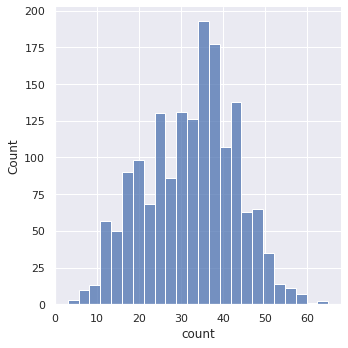

In [54]:
sns.displot(accidents_per_day, x="count")

**Biggest number of accidents was in New Year Holiday, probably related to consume of alcohool and driving. Number of accidents is quite similar to normal/gaussian distribution. It enable us to use metrics like MAPE to measure model performance.**

In [30]:
# Sort by day
accidents_per_day = accidents_per_day.sort_values("date")
accidents_per_day

,date,count
462,2015-06-01,39
71,2015-06-02,49
156,2015-06-03,46
1081,2015-06-04,28
418,2015-06-05,40
...,...,...
596,2019-12-27,37
1122,2019-12-28,27
1555,2019-12-29,15
1315,2019-12-30,23


<AxesSubplot:xlabel='date', ylabel='count'>

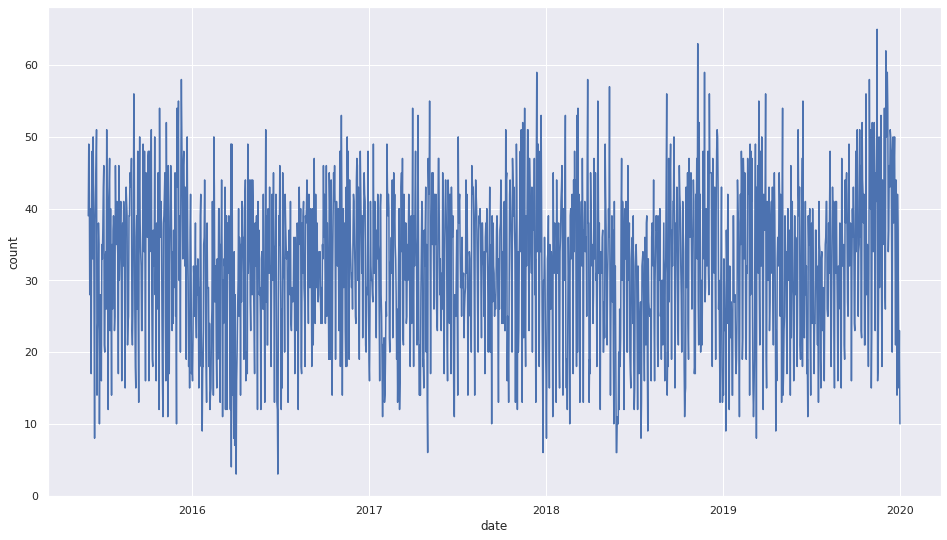

In [31]:
sns.lineplot(x="date", y="count",data=accidents_per_day)

In [32]:
accidents_per_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 462 to 1654
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1675 non-null   datetime64[ns]
 1   count   1675 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 103.8 KB


In [33]:
accidents_per_day = accidents_per_day[accidents_per_day["date"].dt.year <= 2019]

**Timeseries seems stationary, but let me make other analysis with less data or by year** 

In [34]:
weekly = accidents_per_day.set_index("date").resample("W").mean().reset_index()
weekly = weekly[weekly["date"].dt.year <= 2019]
weekly

,date,count
0,2015-06-07,36.000000
1,2015-06-14,35.571429
2,2015-06-21,34.142857
3,2015-06-28,24.000000
4,2015-07-05,33.571429
...,...,...
234,2019-12-01,38.142857
235,2019-12-08,50.714286
236,2019-12-15,41.571429
237,2019-12-22,41.000000


<AxesSubplot:xlabel='date', ylabel='count'>

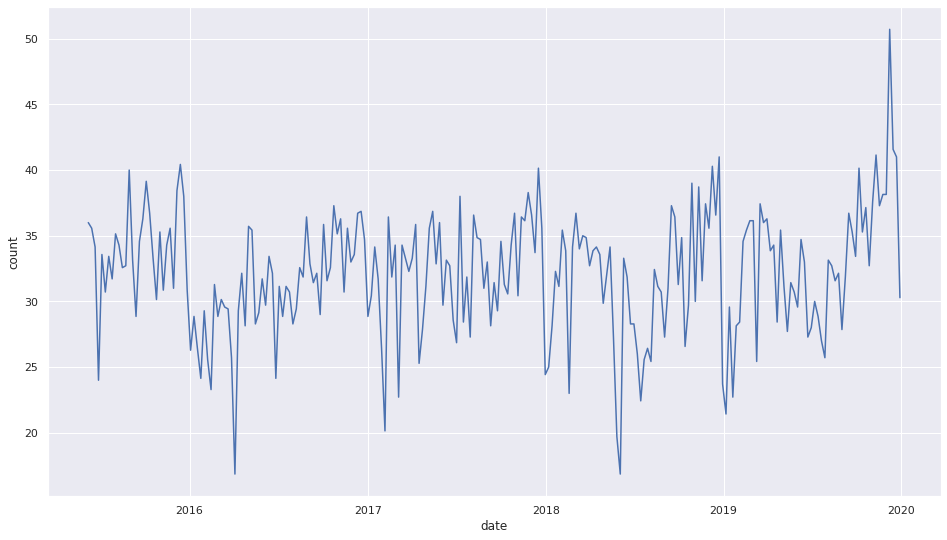

In [35]:
sns.lineplot(x="date", y="count",data=weekly)

**Let me check if all years have same pattern and see if it has a growth behavior**

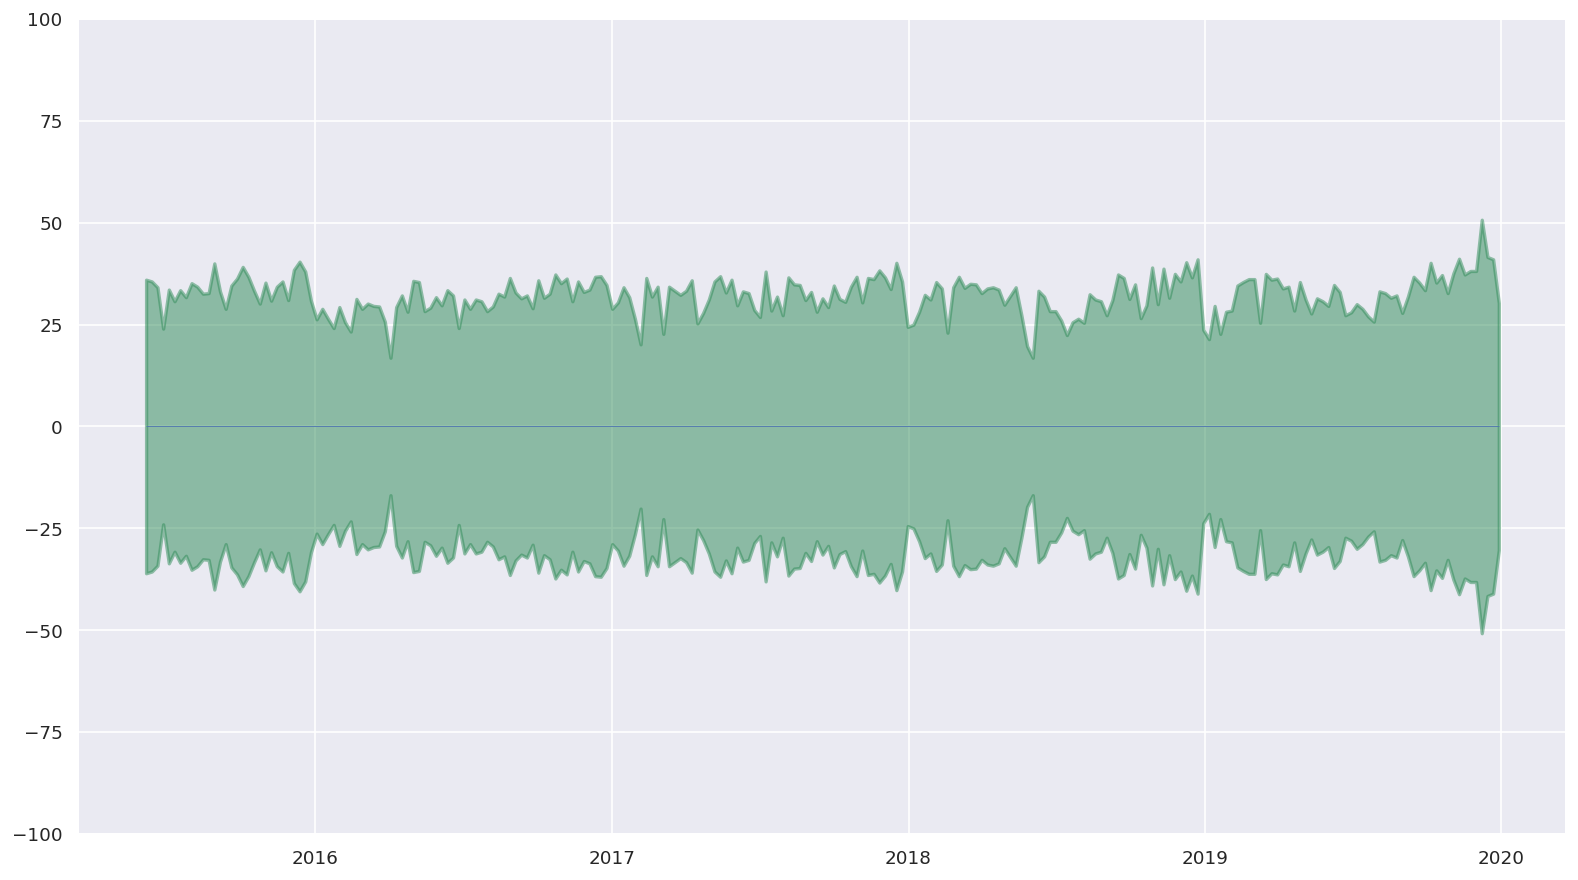

In [36]:
x = weekly['date'].values
y1 = weekly['count'].values

# Using matplotlib because of fill_between. It seems a little bit more complicated using seaborn
fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-100, 100)
plt.hlines(y=0, xmin=np.min(weekly['date']), xmax=np.max(weekly['date']), linewidth=.5)
plt.show()

In [37]:
weekly["year"] = weekly.date.dt.year
weekly["week"] = weekly.date.dt.week
weekly

/run/user/1000/ipykernel_2394295/785975079.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weekly["week"] = weekly.date.dt.week


,date,count,year,week
0,2015-06-07,36.000000,2015,23
1,2015-06-14,35.571429,2015,24
2,2015-06-21,34.142857,2015,25
3,2015-06-28,24.000000,2015,26
4,2015-07-05,33.571429,2015,27
...,...,...,...,...
234,2019-12-01,38.142857,2019,48
235,2019-12-08,50.714286,2019,49
236,2019-12-15,41.571429,2019,50
237,2019-12-22,41.000000,2019,51


<AxesSubplot:xlabel='week', ylabel='count'>

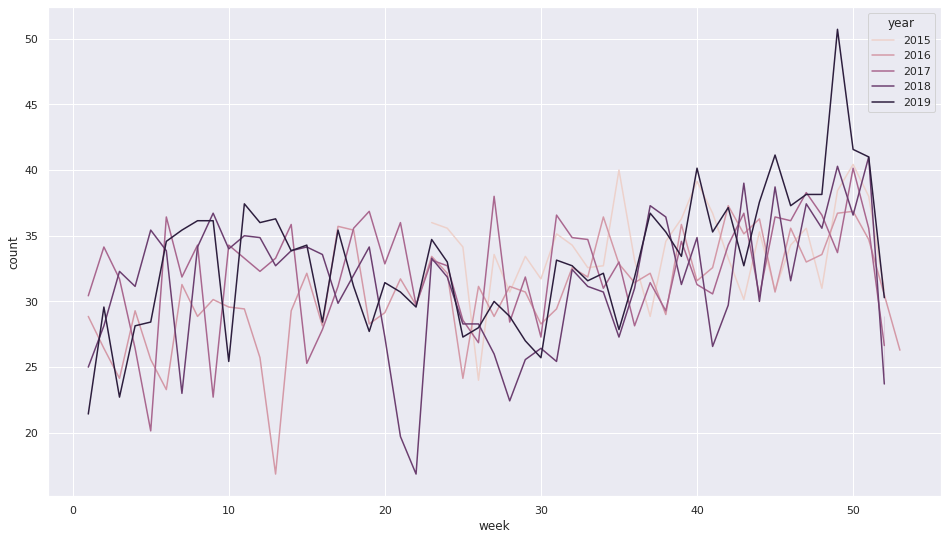

In [38]:
sns.lineplot(x="week", y="count",hue="year",data=weekly)

**Separate month,day,year from date**

In [39]:
accidents_per_day["day"] = accidents_per_day["date"].dt.day
accidents_per_day["year"] = accidents_per_day["date"].dt.year
accidents_per_day["month"] = accidents_per_day["date"].dt.month


<AxesSubplot:xlabel='month', ylabel='count'>

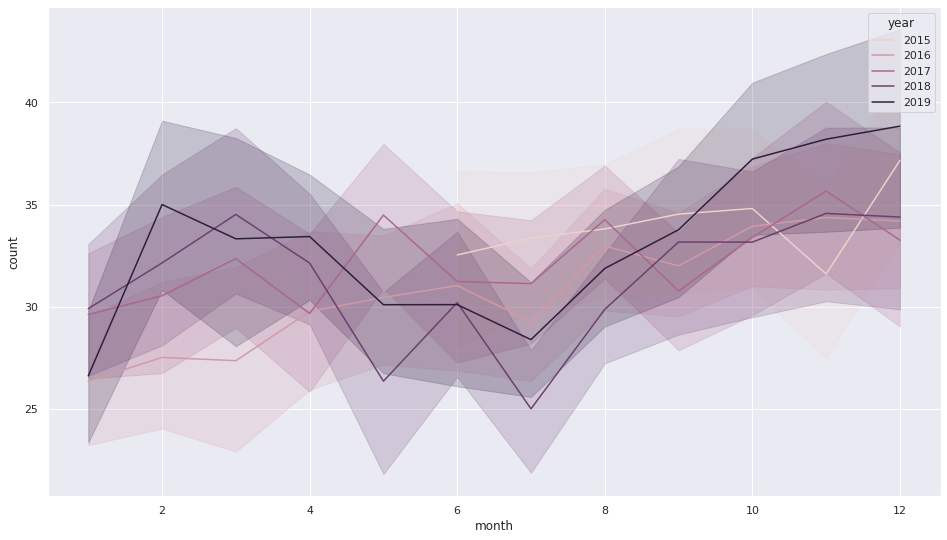

In [40]:
sns.lineplot(x="month", y="count",hue="year",data=accidents_per_day)

**These graphs above show a small trend for high number of accidents in the second semester. The most protuberant is 2019 (may non-stationary). Probably, the reason behind this is the number of holidays and parties in the final of the year. People used to drink more on holidays, and we know that alcohool and driving do not mix well.**

# 2.1 Statistical analysis and test for stationary 

**We can use some statistic and test to see if our series is stanionary or not. We can calculate variance and mean between two parts of the series and see if they closed to each other. If not, probably this series is not stationary. After we can improve our analysis using Augmented Dickey Fuller test.**

In [41]:
values = accidents_per_day["count"].values
test_stationary_serie(values)

Mean1: 31.841099163679807, Mean2:32.35799522673031
Var1: 105.96638732230515, Var2: 126.98878452503688
ADF Statistic: -6.60469972183816
p-value: 6.601348411803381e-09
Critial Values:
   1%, -3.434314582398813
Critial Values:
   5%, -2.8632911365771654
Critial Values:
   10%, -2.5677022641423703
It seems stationary
---------


**According to Augmented Dickey Fuller test, it rejects the null hypothesis (Assume that a temporal series is non-stationary). So, in that case for the whole temporal series, we can accept the fact that it is stationary. But, let make the same tests for each years**

In [42]:
years = accidents_per_day.year.unique().tolist()
for year in years:
    print(f"Test year: {year}")
    values = accidents_per_day[accidents_per_day["year"] == year]["count"].values
    test_stationary_serie(values)

Test year: 2015
Mean1: 33.299065420560744, Mean2:34.67289719626168
Var1: 117.92925146300986, Var2: 127.37898506419775
ADF Statistic: -3.476190630049224
p-value: 0.008620042558332867
Critial Values:
   1%, -3.4638151713286316
Critial Values:
   5%, -2.876250632135043
Critial Values:
   10%, -2.574611347821651
It seems stationary
---------
Test year: 2016
Mean1: 28.775956284153004, Mean2:32.77049180327869
Var1: 114.29406670847146, Var2: 79.1057959329929
ADF Statistic: -3.397296346179619
p-value: 0.011051384997729088
Critial Values:
   1%, -3.449226932880019
Critial Values:
   5%, -2.869857365438656
Critial Values:
   10%, -2.571201085130664
It seems stationary
---------
Test year: 2017
Mean1: 31.307692307692307, Mean2:33.114754098360656
Var1: 102.66356720202874, Var2: 102.56060198871272
ADF Statistic: -4.017949040770602
p-value: 0.001319386760540881
Critial Values:
   1%, -3.44911857009962
Critial Values:
   5%, -2.8698097654570507
Critial Values:
   10%, -2.5711757061225153
It seems sta

**The last year, 2019, seems to be non-stationary, lets take a look again on this year**

<AxesSubplot:xlabel='date', ylabel='count'>

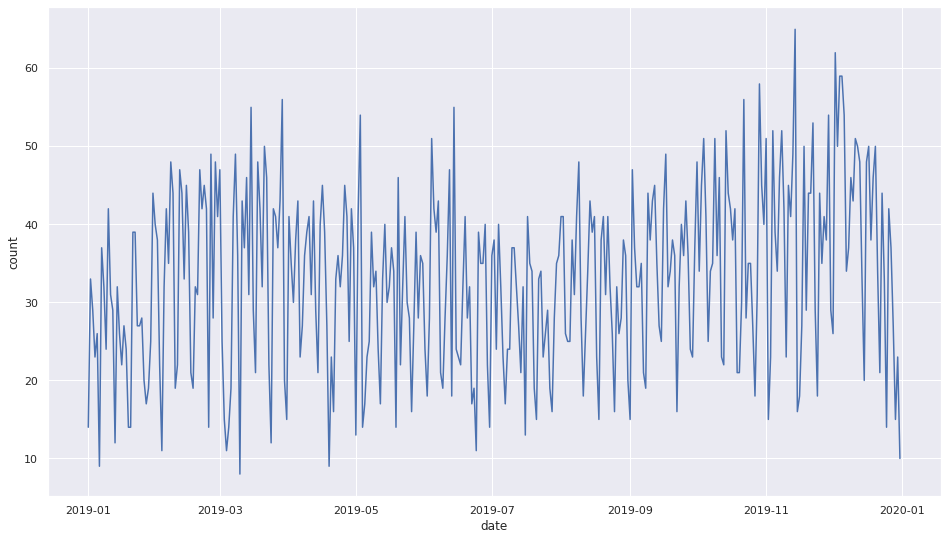

In [43]:
sns.lineplot(x="date", y="count",data=accidents_per_day[accidents_per_day["year"] == 2019])

<AxesSubplot:xlabel='week', ylabel='count'>

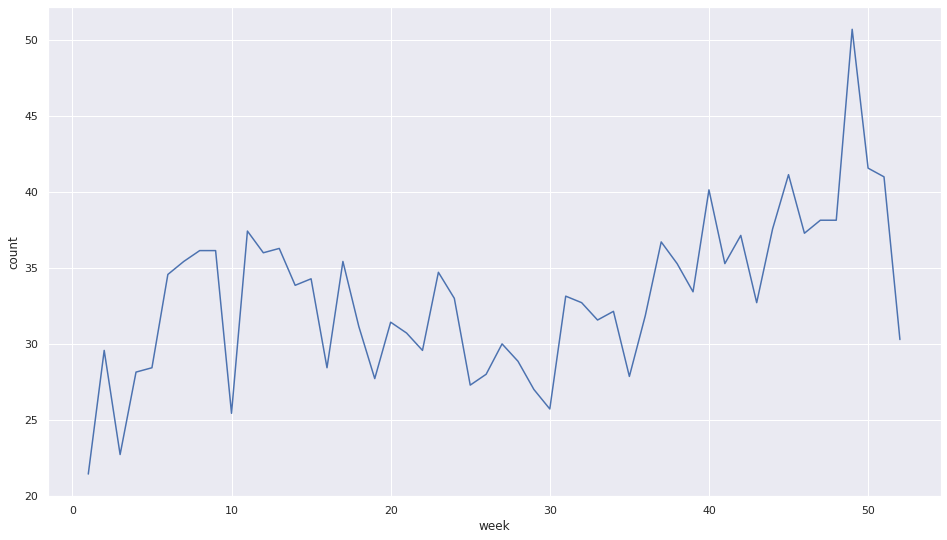

In [44]:
sns.lineplot(x="week", y="count",data=weekly[weekly["year"] == 2019])

**We can observer a small trend in the second semester of 2019**

# 2.2 Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 8)'>

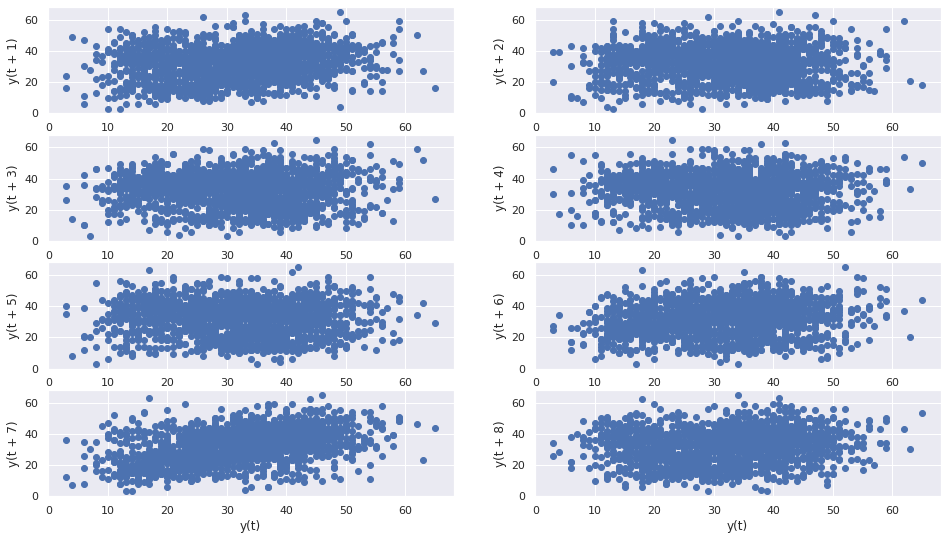

In [45]:
c1, c2, c3, c4, c5,c6,c7,c8 = sns.color_palette("husl", 8)
ax1 = plt.subplot2grid((4,2), (0,0))
ax2 = plt.subplot2grid((4,2), (0,1))
ax3 = plt.subplot2grid((4,2), (1,0))
ax4 = plt.subplot2grid((4,2), (1,1))
ax5 = plt.subplot2grid((4,2), (2,0))
ax6 = plt.subplot2grid((4,2), (2,1))
ax7 = plt.subplot2grid((4,2), (3,0))
ax8 = plt.subplot2grid((4,2), (3,1))

pd.plotting.lag_plot(accidents_per_day["count"], lag=1,ax=ax1)
pd.plotting.lag_plot(accidents_per_day["count"], lag=2,ax=ax2)
pd.plotting.lag_plot(accidents_per_day["count"], lag=3,ax=ax3)
pd.plotting.lag_plot(accidents_per_day["count"], lag=4,ax=ax4)
pd.plotting.lag_plot(accidents_per_day["count"], lag=5,ax=ax5)
pd.plotting.lag_plot(accidents_per_day["count"], lag=6,ax=ax6)
pd.plotting.lag_plot(accidents_per_day["count"], lag=7,ax=ax7)
pd.plotting.lag_plot(accidents_per_day["count"], lag=8,ax=ax8)



**Seems that only t+7 has a small correlation**

In [46]:
days = 28
temp = deepcopy(accidents_per_day)
for day in range(1,days+1):
    result = calculate_lag_features(day,temp)
    accidents_per_day = accidents_per_day.merge(result,on="date")

<AxesSubplot:>

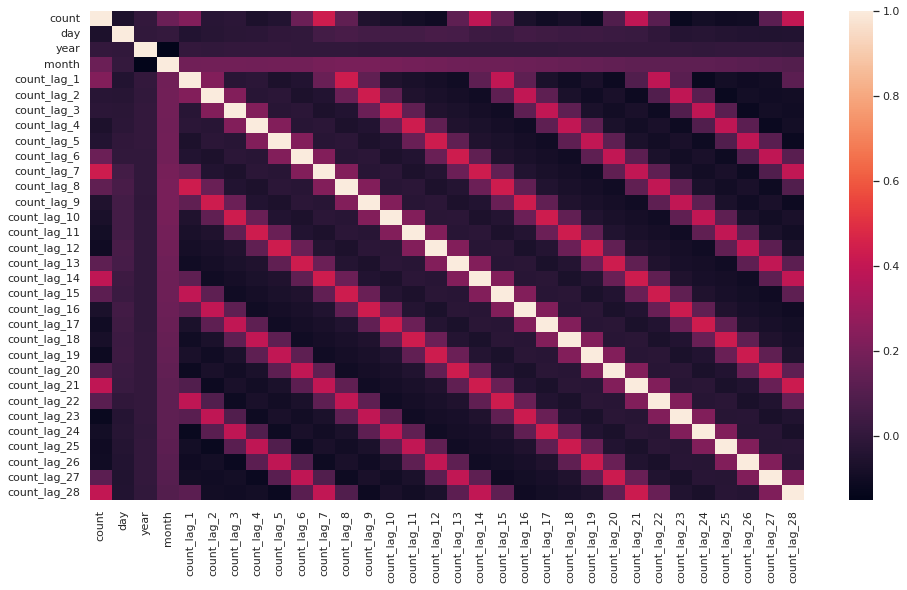

In [47]:
corr = accidents_per_day.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

**Seems like 7 days lag features and the days arround it are the ones with a valuable correlation**

In [48]:
# More lag features, but for distant times 
days = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
temp = deepcopy(accidents_per_day)
for day in days:
    result = calculate_lag_features(day,temp)
    accidents_per_day = accidents_per_day.merge(result,on="date")

<AxesSubplot:>

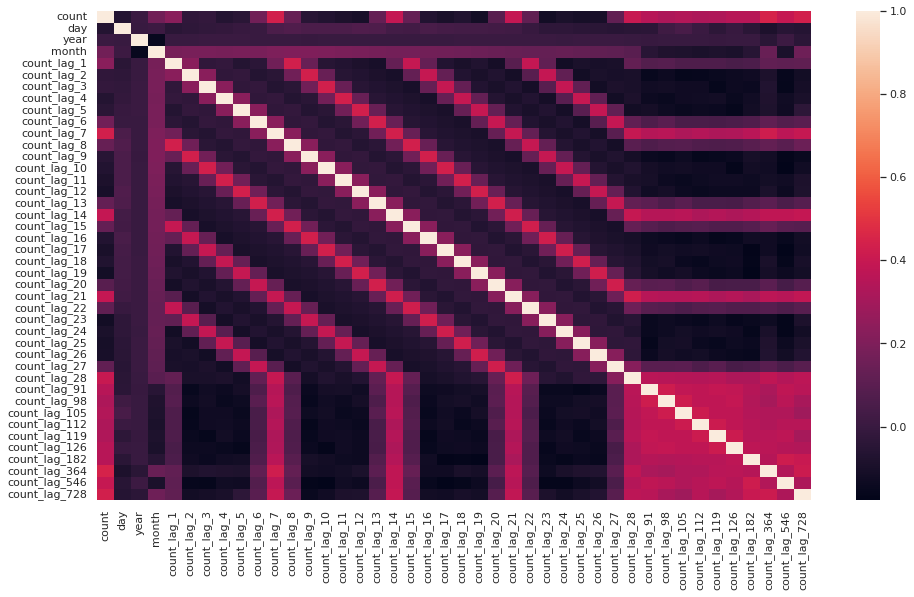

In [49]:
corr = accidents_per_day.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

**We can that far away lag features (3,6,12,18,24) months have a good correlation with number of accidents. Maybe it happens because of human behavior cycle (Do the same thing you did one months before, go to work, holidays, drink and etc) or can that accidents happen because of structural problem in a specific place (No signs and etc) and government is lazy to fix them**

# Feature Engineering

## Conclusions

- Features created:
    - Week of the year (Holidays)
    - Day of the week (Weekend or not) 
    - Week of the month (People lean to go on holidays in the beginning of the month because they haven't spent all they salary yet)
    - Day of the year (Holidays, cycle)
    - Dummy variables:
        - month, day of the week, week of the month

In [50]:
# Week of the year
accidents_per_day["week"] = accidents_per_day.date.dt.week
# Day of the week
accidents_per_day["day_of_the_week"] = accidents_per_day["date"].dt.dayofweek
# Is weekend?
accidents_per_day["is_weekend"] = accidents_per_day["date"].dt.dayofweek > 4
# Week of the month
accidents_per_day["week_of_the_month"] = accidents_per_day["date"].apply(week_of_month)
# Day of the year
accidents_per_day['day_of_the_year'] = accidents_per_day["date"].dt.dayofyear 
# Create dummies variables
accidents_per_day = pd.get_dummies(accidents_per_day, columns=['day_of_the_week', 'month',"week_of_the_month"])

/run/user/1000/ipykernel_2394295/664686415.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  accidents_per_day["week"] = accidents_per_day.date.dt.week


In [51]:
accidents_per_day = accidents_per_day.drop(columns="year")
accidents_per_day

,date,count,day,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,...,month_9,month_10,month_11,month_12,week_of_the_month_0,week_of_the_month_1,week_of_the_month_2,week_of_the_month_3,week_of_the_month_4,week_of_the_month_5
0,2015-06-01,39,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,2015-06-02,49,2,39.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2,2015-06-03,46,3,49.0,39.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,2015-06-04,28,4,46.0,49.0,39.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
4,2015-06-05,40,5,28.0,46.0,49.0,39.0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,2019-12-27,37,27,42.0,14.0,33.0,44.0,21.0,34.0,50.0,...,0,0,0,1,0,0,0,0,1,0
1671,2019-12-28,27,28,37.0,42.0,14.0,33.0,44.0,21.0,34.0,...,0,0,0,1,0,0,0,0,1,0
1672,2019-12-29,15,29,27.0,37.0,42.0,14.0,33.0,44.0,21.0,...,0,0,0,1,0,0,0,0,1,0
1673,2019-12-30,23,30,15.0,27.0,37.0,42.0,14.0,33.0,44.0,...,0,0,0,1,0,0,0,0,0,1


In [52]:
accidents_per_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 0 to 1674
Data columns (total 69 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1675 non-null   datetime64[ns]
 1   count                1675 non-null   int64         
 2   day                  1675 non-null   int64         
 3   count_lag_1          1674 non-null   float64       
 4   count_lag_2          1673 non-null   float64       
 5   count_lag_3          1672 non-null   float64       
 6   count_lag_4          1671 non-null   float64       
 7   count_lag_5          1670 non-null   float64       
 8   count_lag_6          1669 non-null   float64       
 9   count_lag_7          1668 non-null   float64       
 10  count_lag_8          1667 non-null   float64       
 11  count_lag_9          1666 non-null   float64       
 12  count_lag_10         1665 non-null   float64       
 13  count_lag_11         1664 non-nul

In [53]:
accidents_per_day.to_csv("./dataset/primary.csv",index=False)